## Introduction

This project demonstrates the process followed to cluster data for New York City. The target data used for the clustering are sports venue categories.  The Foursquare API was used to explore neighborhoods in New York City. The **explore** function was used to get the most common venue categories in each neighborhood, and this datasets were the filtered to extract the target sports venue categories. The *k*-means clustering algorithm was used to create the optimal number of clusters for New York City. We use the elbow method as a way to estimate the optimal number of clusters. Finally, the Folium library was used to visualize the neighborhoods in New York City and their emerging clusters.

## Table of Contents

<div class="alert alert-block alert-info" style="margin-top: 20px">

<font size = 3>

1. <a href="#item1">Download and Explore Dataset</a>

2. <a href="#item2">Explore Neighborhoods in New York City</a>

3. <a href="#item3">Analyze Each Neighborhood</a>

4. <a href="#item4">Cluster Neighborhoods</a>

5. <a href="#item5">Examine Clusters</a>    
</font>
</div>

Before we get the data and start exploring it, let's download all the dependencies that we will need.

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2020.6.20  |       hecda079_0         145 KB  conda-forge
    certifi-2020.6.20          |   py36h9f0ad1d_0         151 KB  conda-forge
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    geopy-1.22.0               |     pyh9f0ad1d_0          63 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         393 KB

The following NEW packages will be INSTALLED:

  geographiclib      conda-forge/noarch::geographiclib-1.50-py_0
  geopy              conda-forge/noarch::geopy-1.22.0-pyh9f0ad1d_0

The following packages will be UPDATED:

  ca-certificates                     2020.4.5

## 1. Download and Explore Dataset

Neighborhood has a total of 5 boroughs and 306 neighborhoods. In order to segement the neighborhoods and explore them, we will essentially need a dataset that contains the 5 boroughs and the neighborhoods that exist in each borough as well as the the latitude and logitude coordinates of each neighborhood. 

This dataset exists for free on the web at: https://geo.nyu.edu/catalog/nyu_2451_34572

We use the `wget` command and downloaded the data from https://cocl.us/new_york_dataset.

In [5]:
!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset
print('Data downloaded!')

Data downloaded!


#### Load and explore the data

Next, let's load the data.

In [6]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

Let's take a quick look at the data.

In [8]:
newyork_data

{'type': 'FeatureCollection',
 'totalFeatures': 306,
 'features': [{'type': 'Feature',
   'id': 'nyu_2451_34572.1',
   'geometry': {'type': 'Point',
    'coordinates': [-73.84720052054902, 40.89470517661]},
   'geometry_name': 'geom',
   'properties': {'name': 'Wakefield',
    'stacked': 1,
    'annoline1': 'Wakefield',
    'annoline2': None,
    'annoline3': None,
    'annoangle': 0.0,
    'borough': 'Bronx',
    'bbox': [-73.84720052054902,
     40.89470517661,
     -73.84720052054902,
     40.89470517661]}},
  {'type': 'Feature',
   'id': 'nyu_2451_34572.2',
   'geometry': {'type': 'Point',
    'coordinates': [-73.82993910812398, 40.87429419303012]},
   'geometry_name': 'geom',
   'properties': {'name': 'Co-op City',
    'stacked': 2,
    'annoline1': 'Co-op',
    'annoline2': 'City',
    'annoline3': None,
    'annoangle': 0.0,
    'borough': 'Bronx',
    'bbox': [-73.82993910812398,
     40.87429419303012,
     -73.82993910812398,
     40.87429419303012]}},
  {'type': 'Feature',
 

All the relevant data is in the *features* key, which is basically a list of the neighborhoods. So, let's define a new variable that includes this data.

In [9]:
neighborhoods_data = newyork_data['features']

Let's take a look at the first item in this list.

In [10]:
neighborhoods_data[0]

{'type': 'Feature',
 'id': 'nyu_2451_34572.1',
 'geometry': {'type': 'Point',
  'coordinates': [-73.84720052054902, 40.89470517661]},
 'geometry_name': 'geom',
 'properties': {'name': 'Wakefield',
  'stacked': 1,
  'annoline1': 'Wakefield',
  'annoline2': None,
  'annoline3': None,
  'annoangle': 0.0,
  'borough': 'Bronx',
  'bbox': [-73.84720052054902,
   40.89470517661,
   -73.84720052054902,
   40.89470517661]}}

#### Transform the data into a *pandas* dataframe

The next task is essentially transforming this data of nested Python dictionaries into a *pandas* dataframe. So let's start by creating an empty dataframe.

In [11]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

Take a look at the empty dataframe to confirm that the columns are as intended.

In [12]:
neighborhoods

,Borough,Neighborhood,Latitude,Longitude


Then let's loop through the data and fill the dataframe one row at a time.

In [13]:
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

Quickly examine the resulting dataframe.

In [14]:
neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


And make sure that the dataset has all 5 boroughs and 306 neighborhoods.

In [16]:
print(len(neighborhoods['Borough'])) #prints the number of items in the list
print(len(neighborhoods['Borough'].unique())) #prints the number of unique items in the list
print(neighborhoods.shape)  #prints the number of rows and columns

print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(neighborhoods['Borough'].unique()),
        neighborhoods.shape[0]
    )
)
print(neighborhoods['Borough'].unique())

306
5
(306, 4)
The dataframe has 5 boroughs and 306 neighborhoods.
['Bronx' 'Manhattan' 'Brooklyn' 'Queens' 'Staten Island']


## 2. Visualize the New York City Map with neighboorhoods

#### Use geopy library to get the latitude and longitude values of New York City.

In order to define an instance of the geocoder, we need to define a user_agent. We will name our agent <em>ny_explorer</em>, as shown below.

In [17]:
address = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
nylocation = geolocator.geocode(address)
nylatitude = nylocation.latitude
nylongitude = nylocation.longitude
print('The geographical coordinates of New York City are {}, {}.'.format(nylatitude, nylongitude))

The geographical coordinates of New York City are 40.7127281, -74.0060152.


We will segment and cluster the neighborhoods in The Bronx, Brooklyn, Manhattan, Queens, and Staten Island. We will also cluster New York City as a whole. So let's slice the original dataframe and create a new dataframe for each of the 5 boroughs.

In [18]:
# The Bronx
bronx_data = neighborhoods[neighborhoods['Borough'] == 'Bronx'].reset_index(drop=True)
bronx_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [19]:
# Manhattan
manhattan_data = neighborhoods[neighborhoods['Borough'] == 'Manhattan'].reset_index(drop=True)
manhattan_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Manhattan,Marble Hill,40.876551,-73.910660
1,Manhattan,Chinatown,40.715618,-73.994279
2,Manhattan,Washington Heights,40.851903,-73.936900
3,Manhattan,Inwood,40.867684,-73.921210
4,Manhattan,Hamilton Heights,40.823604,-73.949688


In [20]:
# Brooklyn
brooklyn_data = neighborhoods[neighborhoods['Borough'] == 'Brooklyn'].reset_index(drop=True)
brooklyn_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Brooklyn,Bay Ridge,40.625801,-74.030621
1,Brooklyn,Bensonhurst,40.611009,-73.995180
2,Brooklyn,Sunset Park,40.645103,-74.010316
3,Brooklyn,Greenpoint,40.730201,-73.954241
4,Brooklyn,Gravesend,40.595260,-73.973471


In [21]:
# Queens
queens_data = neighborhoods[neighborhoods['Borough'] == 'Queens'].reset_index(drop=True)
queens_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Queens,Astoria,40.768509,-73.915654
1,Queens,Woodside,40.746349,-73.901842
2,Queens,Jackson Heights,40.751981,-73.882821
3,Queens,Elmhurst,40.744049,-73.881656
4,Queens,Howard Beach,40.654225,-73.838138


In [22]:
# Staten Island
statenisland_data = neighborhoods[neighborhoods['Borough'] == 'Staten Island'].reset_index(drop=True)
statenisland_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Staten Island,St. George,40.644982,-74.079353
1,Staten Island,New Brighton,40.640615,-74.087017
2,Staten Island,Stapleton,40.626928,-74.077902
3,Staten Island,Rosebank,40.615305,-74.069805
4,Staten Island,West Brighton,40.631879,-74.107182


Lets get the geographical coordinates of the 5 boroughs: 'Bronx' 'Manhattan' 'Brooklyn' 'Queens' 'Staten Island'

In [23]:
address1 = 'Bronx, NY'
geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address1)
latitude = location.latitude
longitude = location.longitude
print('The geographical coordinates of The Bronx are {}, {}.'.format(latitude, longitude))

address2 = 'Manhattan, NY'
geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address2)
latitude = location.latitude
longitude = location.longitude
print('The geographical coordinates of Manhattan are {}, {}.'.format(latitude, longitude))

address3 = 'Brooklyn, NY'
geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address3)
latitude = location.latitude
longitude = location.longitude
print('The geographical coordinates of Brooklyn are {}, {}.'.format(latitude, longitude))

address4 = 'Queens, NY'
geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address4)
latitude = location.latitude
longitude = location.longitude
print('The geographical coordinates of Queens are {}, {}.'.format(latitude, longitude))

address5 = 'Staten Island, NY'
geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address5)
latitude = location.latitude
longitude = location.longitude
print('The geographical coordinates of Staten Island are {}, {}.'.format(latitude, longitude))

The geographical coordinates of The Bronx are 40.8466508, -73.8785937.
The geographical coordinates of Manhattan are 40.7896239, -73.9598939.
The geographical coordinates of Brooklyn are 40.6501038, -73.9495823.
The geographical coordinates of Queens are 40.7498243, -73.7976337.
The geographical coordinates of Staten Island are 40.5834557, -74.1496048.


#### Create a map of New York with neighborhoods superimposed on top.

We use **Folium**, a great visualization library, to visualize the map of New York City with the different neighboorhoods per borough. The zoom function (+ and - buttons) can be used to zoom into the map, and clicking on each circle mark reveals the name of the neighborhood and its respective borough.
We will now visualize the 5 boroughs and the neighborhoods in it. ['Bronx' 'Manhattan' 'Brooklyn' 'Queens' 'Staten Island']

In [30]:
# create map of New York using latitude and longitude values
map_newyork = folium.Map(location=[nylatitude, nylongitude], zoom_start=10)

# add The Bronx markers to map
for lat, lng, borough, neighborhood in zip(bronx_data['Latitude'], bronx_data['Longitude'], bronx_data['Borough'], bronx_data['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='yellow',
        fill=True,
        #fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    
# add Manhattan markers to map
for lat, lng, borough, neighborhood in zip(manhattan_data['Latitude'], manhattan_data['Longitude'], manhattan_data['Borough'], manhattan_data['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        #fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    
# add Brooklyn markers to map
for lat, lng, borough, neighborhood in zip(brooklyn_data['Latitude'], brooklyn_data['Longitude'], brooklyn_data['Borough'], brooklyn_data['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='green',
        fill=True,
        #fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)    
    
# add Queens markers to map
for lat, lng, borough, neighborhood in zip(queens_data['Latitude'], queens_data['Longitude'], queens_data['Borough'], queens_data['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='orange',
        fill=True,
        #fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    
# add Staten Island markers to map
for lat, lng, borough, neighborhood in zip(statenisland_data['Latitude'], statenisland_data['Longitude'], statenisland_data['Borough'], statenisland_data['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        #fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    
#-----------------------------------------------------
# Add a legend for the clusters by Colin Talbert @ http://nbviewer.jupyter.org/gist/talbertc-usgs/18f8901fc98f109f2b71156cf3ac81cd
from branca.element import Template, MacroElement

template = """
{% macro html(this, kwargs) %}

<!doctype html>
<html lang="en">
<head>
  <meta charset="utf-8">
  <meta name="viewport" content="width=device-width, initial-scale=1">
  <title>jQuery UI Draggable - Default functionality</title>
  <link rel="stylesheet" href="//code.jquery.com/ui/1.12.1/themes/base/jquery-ui.css">

  <script src="https://code.jquery.com/jquery-1.12.4.js"></script>
  <script src="https://code.jquery.com/ui/1.12.1/jquery-ui.js"></script>
  
  <script>
  $( function() {
    $( "#maplegend" ).draggable({
                    start: function (event, ui) {
                        $(this).css({
                            right: "auto",
                            top: "auto",
                            bottom: "auto"
                        });
                    }
                });
});

  </script>
</head>
<body>

<div id='maplegend' class='maplegend' 
    style='position: absolute; z-index:9999; border:2px solid grey; background-color:rgba(255, 255, 255, 0.8);
     border-radius:6px; padding: 10px; font-size:14px; right: 20px; bottom: 20px;'>
     
<div class='legend-title'>NYC Boroughs Legend</div>
<div class='legend-scale'>
  <ul class='legend-labels'>
    <li><span style='background:yellow;opacity:0.7;'></span>The Bronx</li>
    <li><span style='background:blue;opacity:0.7;'></span>Manhattan</li>
    <li><span style='background:green;opacity:0.7;'></span>Brooklyn</li>
    <li><span style='background:orange;opacity:0.7;'></span>Queens</li>
    <li><span style='background:red;opacity:0.7;'></span>Staten Island</li>
  </ul>
</div>
</div>
 
</body>
</html>

<style type='text/css'>
  .maplegend .legend-title {
    text-align: left;
    margin-bottom: 5px;
    font-weight: bold;
    font-size: 90%;
    }
  .maplegend .legend-scale ul {
    margin: 0;
    margin-bottom: 5px;
    padding: 0;
    float: left;
    list-style: none;
    }
  .maplegend .legend-scale ul li {
    font-size: 80%;
    list-style: none;
    margin-left: 0;
    line-height: 18px;
    margin-bottom: 2px;
    }
  .maplegend ul.legend-labels li span {
    display: block;
    float: left;
    height: 16px;
    width: 30px;
    margin-right: 5px;
    margin-left: 0;
    border: 1px solid #999;
    }
  .maplegend .legend-source {
    font-size: 80%;
    color: #777;
    clear: both;
    }
  .maplegend a {
    color: #777;
    }
</style>
{% endmacro %}"""

macro = MacroElement()
macro._template = Template(template)

map_newyork.get_root().add_child(macro)
#-----------------------------------------------------

map_newyork.save('NYC_Boroughs_Map.html')  

# Display the markers on the New York City map   
map_newyork

## 3. Explore Neighborhoods in 5 Boroughs

Next, we are going to start utilizing the Foursquare API to explore the neighborhoods and segment them.

#### Define Foursquare Credentials and Version

In [2]:
CLIENT_ID = 'your Foursquare ID' # your Foursquare ID
CLIENT_SECRET = 'your Foursquare Secret' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: your Foursquare ID
CLIENT_SECRET:your Foursquare Secret


#### Let's explore the first neighborhood in our dataframe.

Get the neighborhood's name.

In [32]:
manhattan_data.loc[0, 'Neighborhood']

'Marble Hill'

Get the neighborhood's latitude and longitude values.

In [33]:
neighborhood_latitude = manhattan_data.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = manhattan_data.loc[0, 'Longitude'] # neighborhood longitude value

neighborhood_name = manhattan_data.loc[0, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Marble Hill are 40.87655077879964, -73.91065965862981.


#### Now, let's get the top 100 venues that are in Marble Hill within a radius of 500 meters.

First, let's create the GET request URL. Name your URL **url**.

In [34]:
# type your answer here
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 # define radius

# create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)

url # display URL

'https://api.foursquare.com/v2/venues/explore?&client_id=JL3U123EIDKDR5AMXGF3QL5U0GR5XDAR00PF31BPGTJFI5LK&client_secret=Q0AN2W3OWJ1ECXDQMT2BIRMDJ5H4XHG1ZMODFG24IDT4RA5O&v=20180605&ll=40.87655077879964,-73.91065965862981&radius=500&limit=100'

Send the GET request and examine the resutls

In [ ]:
results = requests.get(url).json()
results

We use the **get_category_type** function that extracts the category of the venue.

In [ ]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

We clean the json and structure the information (which is in the *items* key) into a *pandas* dataframe.

In [ ]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

And how many venues were returned by Foursquare?

In [ ]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

#### Let's create a function to repeat the same process to all the neighborhoods in all the boroughs

In [ ]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

#### We run the above function on each neighborhood and create a new dataframe for each borough. ['Bronx' 'Manhattan' 'Brooklyn' 'Queens' 'Staten Island']

In [40]:
# venues for The Bronx

bronx_venues = getNearbyVenues(names=bronx_data['Neighborhood'],
                                   latitudes=bronx_data['Latitude'],
                                   longitudes=bronx_data['Longitude']
                                  )

Mount Hope
Bronxdale
Allerton
Kingsbridge Heights


In [41]:
# venues for Manhattan

manhattan_venues = getNearbyVenues(names=manhattan_data['Neighborhood'],
                                   latitudes=manhattan_data['Latitude'],
                                   longitudes=manhattan_data['Longitude']
                                  )

Marble Hill
Chinatown
Washington Heights
Inwood
Hamilton Heights
Manhattanville
Central Harlem
East Harlem
Upper East Side
Yorkville
Lenox Hill
Roosevelt Island
Upper West Side
Lincoln Square
Clinton
Midtown
Murray Hill
Chelsea
Greenwich Village
East Village
Lower East Side
Tribeca
Little Italy
Soho
West Village
Manhattan Valley
Morningside Heights
Gramercy
Battery Park City
Financial District
Carnegie Hill
Noho
Civic Center
Midtown South
Sutton Place
Turtle Bay
Tudor City
Stuyvesant Town
Flatiron
Hudson Yards


In [42]:
# venues for Brooklyn

brooklyn_venues = getNearbyVenues(names=brooklyn_data['Neighborhood'],
                                   latitudes=brooklyn_data['Latitude'],
                                   longitudes=brooklyn_data['Longitude']
                                  )

Bay Ridge
Bensonhurst
Sunset Park
Greenpoint
Gravesend
Brighton Beach
Sheepshead Bay
Manhattan Terrace
Flatbush
Crown Heights
East Flatbush
Kensington
Windsor Terrace
Prospect Heights
Brownsville
Williamsburg
Bushwick
Bedford Stuyvesant
Brooklyn Heights
Cobble Hill
Carroll Gardens
Red Hook
Gowanus
Fort Greene
Park Slope
Cypress Hills
East New York
Starrett City
Canarsie
Flatlands
Mill Island
Manhattan Beach
Coney Island
Bath Beach
Borough Park
Dyker Heights
Gerritsen Beach
Marine Park
Clinton Hill
Sea Gate
Downtown
Boerum Hill
Prospect Lefferts Gardens
Ocean Hill
City Line
Bergen Beach
Midwood
Prospect Park South
Georgetown
East Williamsburg
North Side
South Side
Ocean Parkway
Fort Hamilton
Ditmas Park
Wingate
Rugby
Remsen Village
New Lots
Paerdegat Basin
Mill Basin
Fulton Ferry
Vinegar Hill
Weeksville
Broadway Junction
Dumbo
Homecrest
Highland Park
Madison
Erasmus


In [43]:
# venues for Queens

queens_venues = getNearbyVenues(names=queens_data['Neighborhood'],
                                   latitudes=queens_data['Latitude'],
                                   longitudes=queens_data['Longitude']
                                  )

Astoria
Woodside
Jackson Heights
Elmhurst
Howard Beach
Corona
Forest Hills
Kew Gardens
Richmond Hill
Flushing
Long Island City
Sunnyside
East Elmhurst
Maspeth
Ridgewood
Glendale
Rego Park
Woodhaven
Ozone Park
South Ozone Park
College Point
Whitestone
Bayside
Auburndale
Little Neck
Douglaston
Glen Oaks
Bellerose
Kew Gardens Hills
Fresh Meadows
Briarwood
Jamaica Center
Oakland Gardens
Queens Village
Hollis
South Jamaica
St. Albans
Rochdale
Springfield Gardens
Cambria Heights
Rosedale
Far Rockaway
Broad Channel
Breezy Point
Steinway
Beechhurst
Bay Terrace
Edgemere
Arverne
Rockaway Beach
Neponsit
Murray Hill
Floral Park
Holliswood
Jamaica Estates
Queensboro Hill
Hillcrest
Ravenswood
Lindenwood
Laurelton
Lefrak City
Belle Harbor
Rockaway Park
Somerville
Brookville
Bellaire
North Corona
Forest Hills Gardens
Jamaica Hills
Utopia
Pomonok
Astoria Heights
Hunters Point
Sunnyside Gardens
Blissville
Roxbury
Middle Village
Malba
Hammels
Bayswater
Queensbridge


In [44]:
# venues for Staten Island

statenisland_venues = getNearbyVenues(names=statenisland_data['Neighborhood'],
                                   latitudes=statenisland_data['Latitude'],
                                   longitudes=statenisland_data['Longitude']
                                  )

St. George
New Brighton
Stapleton
Rosebank
West Brighton
Grymes Hill
Todt Hill
South Beach
Port Richmond
Mariner's Harbor
Port Ivory
Castleton Corners
New Springville
Travis
New Dorp
Oakwood
Great Kills
Eltingville
Annadale
Woodrow
Tottenville
Tompkinsville
Silver Lake
Sunnyside
Park Hill
Westerleigh
Graniteville
Arlington
Arrochar
Grasmere
Old Town
Dongan Hills
Midland Beach
Grant City
New Dorp Beach
Bay Terrace
Huguenot
Pleasant Plains
Butler Manor
Charleston
Rossville
Arden Heights
Greenridge
Heartland Village
Chelsea
Bloomfield
Bulls Head
Richmond Town
Shore Acres
Clifton
Concord
Emerson Hill
Randall Manor
Howland Hook
Elm Park
Manor Heights
Willowbrook
Sandy Ground
Egbertville
Prince's Bay
Lighthouse Hill
Richmond Valley
Fox Hills


#### Let's check the size of the resulting dataframes

In [45]:
# Let's check the shapes of the dataframes
print('The Bronx dataframe shape: ',bronx_venues.shape)
print('The Manhattan dataframe shape: ', manhattan_venues.shape)
print('The Brooklyn dataframe shape: ', brooklyn_venues.shape)
print('The Queens dataframe shape: ', queens_venues.shape)
print('The Staten Island dataframe shape: ', statenisland_venues.shape)

The Bronx dataframe shape:  (1183, 7)
The Manhattan dataframe shape:  (3140, 7)
The Brooklyn dataframe shape:  (2722, 7)
The Queens dataframe shape:  (2089, 7)
The Staten Island dataframe shape:  (849, 7)


#### Get a list of all venue categories in the 5 boroughs

In [46]:
# The Bronx
bronx_venue_list = bronx_venues['Venue Category'].unique()
print("The Bronx venue categories: ", bronx_venue_list)

The Bronx venue categories:  ['Dessert Shop' 'Pharmacy' 'Ice Cream Shop' 'Donut Shop' 'Gas Station'
 'Sandwich Place' 'Food' 'Pizza Place' 'Laundromat' 'Discount Store'
 'Post Office' 'Bagel Shop' 'Grocery Store' 'Fast Food Restaurant'
 'Restaurant' 'Bus Station' 'Baseball Field' 'Deli / Bodega'
 'Basketball Court' 'Park' 'Caribbean Restaurant' 'Diner'
 'Seafood Restaurant' 'Bowling Alley' 'Automotive Shop'
 'Food & Drink Shop' 'Platform' 'Convenience Store' 'Bus Stop' 'Plaza'
 'River' 'Bank' 'Food Truck' 'Gym' 'Gourmet Shop'
 'Latin American Restaurant' 'Pub' 'Burger Joint' 'Beer Bar'
 'Warehouse Store' 'Coffee Shop' 'Spanish Restaurant' 'Mexican Restaurant'
 'Bar' 'Wings Joint' 'Thrift / Vintage Store' 'Trail' 'Supermarket'
 'Bakery' 'Candy Store' 'Café' 'Rental Car Location' 'Fried Chicken Joint'
 'Breakfast Spot' 'Mattress Store' 'Pet Store' 'Supplement Shop'
 'Shipping Store' 'Sports Bar' 'Furniture / Home Store' 'Liquor Store'
 'Chinese Restaurant' 'Outdoor Sculpture' 'Bus Line' 

In [47]:
# Manhattan
manhattan_venue_list = manhattan_venues['Venue Category'].unique()
print("Manhattan venue categories: ", manhattan_venue_list)

Manhattan venue categories:  ['Pizza Place' 'Yoga Studio' 'Diner' 'Coffee Shop' 'Donut Shop' 'Pharmacy'
 'Gym' 'Tennis Stadium' 'Department Store' 'Supplement Shop'
 'Discount Store' 'Sandwich Place' 'Seafood Restaurant' 'Ice Cream Shop'
 'American Restaurant' 'Video Game Store' 'Miscellaneous Shop'
 'Steakhouse' 'Bank' 'Kids Store' 'Deli / Bodega' 'Hotel'
 'Greek Restaurant' 'Chinese Restaurant' 'Cocktail Bar'
 'English Restaurant' 'Museum' 'Bakery' 'Spa' 'Hotpot Restaurant'
 'Bike Shop' 'Tea Room' 'Noodle House' 'New American Restaurant'
 'Indie Movie Theater' 'Bubble Tea Shop' 'Dessert Shop' 'Asian Restaurant'
 'Historic Site' 'Spanish Restaurant' 'Salon / Barbershop' 'Boutique'
 'Roof Deck' 'Thai Restaurant' 'Garden Center' 'Furniture / Home Store'
 'Korean Restaurant' 'Music Venue' 'Malay Restaurant' 'Cosmetics Shop'
 'Karaoke Bar' 'Vietnamese Restaurant' 'Supermarket' 'Organic Grocery'
 'Snack Place' 'Mexican Restaurant' 'Gift Shop' 'Sports Club'
 'Optical Shop' 'Paper / Office S

In [48]:
# Brooklyn
brooklyn_venue_list = brooklyn_venues['Venue Category'].unique()
print("Brooklyn venue categories: ", brooklyn_venue_list)

Brooklyn venue categories:  ['Spa' 'Bagel Shop' 'Pizza Place' 'Juice Bar' 'Taco Place'
 'Breakfast Spot' 'Grocery Store' 'Chinese Restaurant'
 'Middle Eastern Restaurant' 'Bar' 'Optical Shop' 'Lounge' 'Bookstore'
 'Greek Restaurant' 'Caucasian Restaurant' 'Italian Restaurant'
 'Ice Cream Shop' 'Sports Bar' 'Coffee Shop' 'Tea Room' 'Café'
 'Sushi Restaurant' 'American Restaurant' 'Hookah Bar' 'Department Store'
 'Seafood Restaurant' 'New American Restaurant' 'Mexican Restaurant'
 'Toy / Game Store' 'Video Game Store' 'Thai Restaurant'
 'Indian Restaurant' 'Sandwich Place' 'Lingerie Store'
 'Vietnamese Restaurant' 'Gym / Fitness Center' 'Pool Hall' 'Kids Store'
 'Dim Sum Restaurant' 'Pharmacy' 'Snack Place' 'Clothing Store'
 'Fast Food Restaurant' 'Mattress Store' 'Supermarket' 'Cosmetics Shop'
 'Yoga Studio' 'Hotel' 'Playground' 'Park' 'Bakery' 'Butcher'
 'Liquor Store' 'Shabu-Shabu Restaurant' 'Noodle House'
 'Hotpot Restaurant' 'Dance Studio' 'Pet Store' 'Flower Shop' 'Donut Shop'
 'A

In [49]:
# Queens
queens_venue_list = queens_venues['Venue Category'].unique()
print("Queens venue categories: ", queens_venue_list)

Queens venue categories:  ['Brazilian Restaurant' 'Gourmet Shop' 'Seafood Restaurant' 'Gym'
 'Middle Eastern Restaurant' 'Martial Arts Dojo' 'Greek Restaurant' 'Pub'
 'Dessert Shop' 'Indian Restaurant' 'Falafel Restaurant' 'Ice Cream Shop'
 'Mediterranean Restaurant' 'Bakery' 'Restaurant' 'Bagel Shop'
 'Health & Beauty Service' 'Mexican Restaurant' 'Food Truck' 'Salad Place'
 'Vegetarian / Vegan Restaurant' 'Pizza Place' 'Bar' 'Grocery Store'
 'American Restaurant' 'Korean Restaurant' 'Thai Restaurant'
 'Bubble Tea Shop' 'Poke Place' 'Food' 'Japanese Restaurant'
 'Cocktail Bar' 'BBQ Joint' 'Cajun / Creole Restaurant'
 'Gym / Fitness Center' 'Hookah Bar' 'Juice Bar' 'Beer Garden'
 'Souvlaki Shop' 'Food & Drink Shop' 'Optical Shop' 'Spa' 'Liquor Store'
 'Coffee Shop' 'Deli / Bodega' 'Italian Restaurant' 'Sandwich Place'
 'Comfort Food Restaurant' 'Burger Joint' 'Latin American Restaurant'
 'Café' 'Wine Shop' 'Sushi Restaurant' 'Moroccan Restaurant'
 'Fast Food Restaurant' 'Filipino Resta

In [50]:
# Staten Island
statenisland_venue_list = statenisland_venues['Venue Category'].unique()
print("Staten Island venue categories: ", statenisland_venue_list)

Staten Island venue categories:  ['Pizza Place' 'Tapas Restaurant' 'Monument / Landmark' 'Baseball Stadium'
 'Burger Joint' 'Theater' 'Italian Restaurant' 'Toy / Game Store' 'Bar'
 'American Restaurant' 'Sporting Goods Shop' 'Farmers Market'
 'Clothing Store' 'Steakhouse' 'Pharmacy' 'Coffee Shop' 'Donut Shop'
 'Outlet Mall' 'Plaza' 'Snack Place' 'Harbor / Marina' 'Scenic Lookout'
 'Bus Station' 'Park' 'Tourist Information Center' 'Discount Store'
 'Bus Stop' 'Bowling Alley' 'Deli / Bodega' 'Playground' 'Bridal Shop'
 'Sandwich Place' 'Sri Lankan Restaurant' 'Asian Restaurant' 'Beer Bar'
 'Spanish Restaurant' 'Skate Park'
 'Residential Building (Apartment / Condo)' 'Restaurant'
 'New American Restaurant' 'Mexican Restaurant' 'Bank'
 'Fast Food Restaurant' 'Pool Hall' 'Cosmetics Shop' 'Chinese Restaurant'
 'Motorcycle Shop' 'Cajun / Creole Restaurant' 'Breakfast Spot'
 'Grocery Store' 'Filipino Restaurant' 'Eastern European Restaurant'
 'Bagel Shop' 'Storage Facility' 'Video Store' 'Ice 

#### Create a list of all sports related and health shop related venues in each borough

In [51]:
# All sports related venues of interest were selected from the venues lists and inserted in "sports_list"
sports_list = target_sports = ['Cycle Studio', 'Athletics & Sports', 'Gymnastics Gym', 'Baseball Field', 'Soccer Field', 'Boxing Gym', 'Martial Arts Dojo', 'Tennis Court', 'Volleyball Court', 'Basketball Court']

In [52]:
# Get all sports related venues in The Bronx
bronx_sports_df = bronx_venues[(bronx_venues['Venue Category'].isin(sports_list))]
bronx_sports_df.reset_index().head()

,index,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,19,Co-op City,40.874294,-73.829939,truman track n field,40.874963,-73.830847,Baseball Field
1,21,Co-op City,40.874294,-73.829939,Section 4 Basketball Courts (Co Op City),40.872412,-73.826302,Basketball Court
2,250,City Island,40.847247,-73.786488,City Island Little League Field,40.843781,-73.784759,Baseball Field
3,427,West Farms,40.839475,-73.877745,Showtime Basketball Courts,40.837026,-73.879587,Basketball Court
4,468,Melrose,40.819754,-73.909422,Senshi Okami Martial Arts Center,40.819295,-73.914158,Martial Arts Dojo


In [53]:
# Get all sports related venues in Manhattan
manhattan_sports_df = manhattan_venues[(manhattan_venues['Venue Category'].isin(sports_list))]
manhattan_sports_df.reset_index().head()

,index,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,370,Central Harlem,40.815976,-73.943211,Harlem Cycle,40.817201,-73.942592,Cycle Studio
1,505,Upper East Side,40.775639,-73.960508,SoulCycle East 83rd,40.776991,-73.955329,Cycle Studio
2,611,Yorkville,40.775930,-73.947118,Asphalt Green Field,40.778580,-73.944448,Soccer Field
3,624,Yorkville,40.775930,-73.947118,Yorkville Tennis Club,40.778263,-73.946289,Athletics & Sports
4,655,Lenox Hill,40.768113,-73.958860,CYC Fitness,40.768988,-73.960797,Cycle Studio


In [54]:
# Get all sports related venues in Brooklyn
brooklyn_sports_df = brooklyn_venues[(brooklyn_venues['Venue Category'].isin(sports_list))]
brooklyn_sports_df.reset_index().head()

,index,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,160,Greenpoint,40.730201,-73.954241,IncrediPole,40.731838,-73.955069,Gymnastics Gym
1,259,Gravesend,40.595260,-73.973471,Gravesend Our Lady Of Grace Field,40.594673,-73.971428,Baseball Field
2,260,Gravesend,40.595260,-73.973471,OMG MMA,40.595364,-73.973755,Martial Arts Dojo
3,274,Gravesend,40.595260,-73.973471,Gene Dunns Shotokan Karate,40.596130,-73.978449,Martial Arts Dojo
4,751,Brooklyn Heights,40.695864,-73.993782,SoulCycle Brooklyn Heights,40.692253,-73.991042,Cycle Studio


In [55]:
# Get all sports related venues in Queens
queens_sports_df = queens_venues[(queens_venues['Venue Category'].isin(sports_list))]
queens_sports_df.reset_index().head()

,index,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,7,Astoria,40.768509,-73.915654,Sitan Muay Thai,40.766108,-73.913224,Martial Arts Dojo
1,344,Corona,40.742382,-73.856825,Barrier Park,40.738163,-73.856062,Basketball Court
2,349,Forest Hills,40.725264,-73.844475,iLoveKickboxing,40.721729,-73.847488,Boxing Gym
3,370,Forest Hills,40.725264,-73.844475,International Karate & Fitness Center,40.722030,-73.847458,Martial Arts Dojo
4,703,Ridgewood,40.708323,-73.901435,Spirit Taekwondo,40.712143,-73.900142,Martial Arts Dojo


In [56]:
# Get all sports related venues in Staten Island
statenisland_sports_df = statenisland_venues[(statenisland_venues['Venue Category'].isin(sports_list))]
statenisland_sports_df.reset_index().head()

,index,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,146,South Beach,40.580247,-74.079553,Ocean Breeze Track & Field Athletic Complex,40.583038,-74.075244,Athletics & Sports
1,196,New Springville,40.594252,-74.164960,Shoalin,40.594849,-74.163313,Martial Arts Dojo
2,218,Travis,40.586314,-74.190737,Schmul Park,40.590105,-74.188300,Baseball Field
3,272,Great Kills,40.549480,-74.149324,Cardinal Cook Center,40.545893,-74.149426,Basketball Court
4,307,Eltingville,40.542231,-74.164331,Island Martial Arts,40.545119,-74.165951,Martial Arts Dojo


In [57]:
# Consolidated dataframe for NYC
NYC_sports_df = pd.concat([bronx_sports_df, manhattan_sports_df, brooklyn_sports_df, queens_sports_df, statenisland_sports_df])

In [58]:
NYC_sports_df = NYC_sports_df.reset_index(drop=True)

In [59]:
NYC_sports_df.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Co-op City,40.874294,-73.829939,truman track n field,40.874963,-73.830847,Baseball Field
1,Co-op City,40.874294,-73.829939,Section 4 Basketball Courts (Co Op City),40.872412,-73.826302,Basketball Court
2,City Island,40.847247,-73.786488,City Island Little League Field,40.843781,-73.784759,Baseball Field
3,West Farms,40.839475,-73.877745,Showtime Basketball Courts,40.837026,-73.879587,Basketball Court
4,Melrose,40.819754,-73.909422,Senshi Okami Martial Arts Center,40.819295,-73.914158,Martial Arts Dojo


In [60]:
NYC_sports_df.tail()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
113,Midland Beach,40.573527,-74.093483,Olympia Activity Center,40.571511,-74.094324,Basketball Court
114,Butler Manor,40.506082,-74.229504,South Shore Babe Ruth League,40.506639,-74.229112,Baseball Field
115,Butler Manor,40.506082,-74.229504,South Shore Little League,40.508100,-74.232781,Baseball Field
116,Bulls Head,40.609592,-74.159409,Willowbrook Park Softball Fields,40.606730,-74.156450,Baseball Field
117,Shore Acres,40.609719,-74.066678,East Shore LL,40.606220,-74.064194,Baseball Field


In [61]:
NYC_sports_df.shape

(118, 7)

Let's check how many venues were returned for each sports category

In [62]:
# The Bronx
bronx_sports = bronx_sports_df.groupby('Venue Category').count()
bronx_sports = bronx_sports[['Neighborhood']]
bronx_sports.rename(columns={'Neighborhood':'Bronx'}, inplace=True)
print(bronx_sports)

# Manhattan
manhattan_sports = manhattan_sports_df.groupby('Venue Category').count()
manhattan_sports = manhattan_sports[['Neighborhood']]
manhattan_sports.rename(columns={'Neighborhood':'Manhattan'}, inplace=True)
print(manhattan_sports)

# Brooklyn
brooklyn_sports = brooklyn_sports_df.groupby('Venue Category').count()
brooklyn_sports = brooklyn_sports[['Neighborhood']]
brooklyn_sports.rename(columns={'Neighborhood':'Brooklyn'}, inplace=True)
print(brooklyn_sports)

# Queens
queens_sports = queens_sports_df.groupby('Venue Category').count()
queens_sports = queens_sports[['Neighborhood']]
queens_sports.rename(columns={'Neighborhood':'Queens'}, inplace=True)
print(queens_sports)

# Staten Island
statenisland_sports = statenisland_sports_df.groupby('Venue Category').count()
statenisland_sports = statenisland_sports[['Neighborhood']]
statenisland_sports.rename(columns={'Neighborhood':'Staten Island'}, inplace=True)
print(statenisland_sports)

# NYC
NYC_sports = NYC_sports_df.groupby('Venue Category').count()
NYC_sports = NYC_sports[['Neighborhood']]
NYC_sports.rename(columns={'Neighborhood':'NYC'}, inplace=True)
print(NYC_sports)

                    Bronx
Venue Category           
Athletics & Sports      1
Baseball Field          5
Basketball Court        4
Martial Arts Dojo       3
Tennis Court            1
                    Manhattan
Venue Category               
Athletics & Sports          3
Baseball Field              1
Basketball Court            1
Boxing Gym                  7
Cycle Studio               17
Martial Arts Dojo           4
Soccer Field                2
Tennis Court                5
Volleyball Court            1
                    Brooklyn
Venue Category              
Athletics & Sports         4
Baseball Field             4
Basketball Court           1
Boxing Gym                 4
Cycle Studio               3
Gymnastics Gym             2
Martial Arts Dojo          4
Soccer Field               1
Tennis Court               4
                    Queens
Venue Category            
Athletics & Sports       4
Baseball Field           4
Basketball Court         4
Boxing Gym               1
Cycle S

#### Merge the dataframes

In [63]:
# Outer merge of all venue categories

venue_category_merged_outer = pd.merge(bronx_sports, manhattan_sports, on='Venue Category', how='outer')
venue_category_merged_outer = pd.merge(venue_category_merged_outer, brooklyn_sports, on='Venue Category', how='outer')
venue_category_merged_outer = pd.merge(venue_category_merged_outer, queens_sports, on='Venue Category', how='outer')
venue_category_merged_outer = pd.merge(venue_category_merged_outer, statenisland_sports, on='Venue Category', how='outer')
venue_category_merged_outer

,Bronx,Manhattan,Brooklyn,Queens,Staten Island
Venue Category,,,,,
Athletics & Sports,1.0,3.0,4.0,4.0,3.0
Baseball Field,5.0,1.0,4.0,4.0,5.0
Basketball Court,4.0,1.0,1.0,4.0,4.0
Martial Arts Dojo,3.0,4.0,4.0,6.0,3.0
Tennis Court,1.0,5.0,4.0,1.0,NaN
Boxing Gym,NaN,7.0,4.0,1.0,NaN
Cycle Studio,NaN,17.0,3.0,1.0,NaN
Soccer Field,NaN,2.0,1.0,NaN,NaN
Volleyball Court,NaN,1.0,NaN,NaN,NaN


In [64]:
# Replace NaN with zero
venue_category_merged_outer.replace(np.nan, 0, inplace=True)
venue_category_merged_outer[['Bronx','Manhattan','Brooklyn','Queens','Staten Island']]

,Bronx,Manhattan,Brooklyn,Queens,Staten Island
Venue Category,,,,,
Athletics & Sports,1.0,3.0,4.0,4.0,3.0
Baseball Field,5.0,1.0,4.0,4.0,5.0
Basketball Court,4.0,1.0,1.0,4.0,4.0
Martial Arts Dojo,3.0,4.0,4.0,6.0,3.0
Tennis Court,1.0,5.0,4.0,1.0,0.0
Boxing Gym,0.0,7.0,4.0,1.0,0.0
Cycle Studio,0.0,17.0,3.0,1.0,0.0
Soccer Field,0.0,2.0,1.0,0.0,0.0
Volleyball Court,0.0,1.0,0.0,0.0,0.0


In [65]:
venue_category_merged_outer = venue_category_merged_outer.astype("int")
venue_category_merged_outer

,Bronx,Manhattan,Brooklyn,Queens,Staten Island
Venue Category,,,,,
Athletics & Sports,1,3,4,4,3
Baseball Field,5,1,4,4,5
Basketball Court,4,1,1,4,4
Martial Arts Dojo,3,4,4,6,3
Tennis Court,1,5,4,1,0
Boxing Gym,0,7,4,1,0
Cycle Studio,0,17,3,1,0
Soccer Field,0,2,1,0,0
Volleyball Court,0,1,0,0,0


In [66]:
venue_category_merged_inner = pd.merge(bronx_sports, manhattan_sports, on='Venue Category')
venue_category_merged_inner = pd.merge(venue_category_merged_inner, brooklyn_sports, on='Venue Category')
venue_category_merged_inner = pd.merge(venue_category_merged_inner, queens_sports, on='Venue Category')
venue_category_merged_inner = pd.merge(venue_category_merged_inner, statenisland_sports, on='Venue Category')
venue_category_merged_inner

,Bronx,Manhattan,Brooklyn,Queens,Staten Island
Venue Category,,,,,
Athletics & Sports,1,3,4,4,3
Baseball Field,5,1,4,4,5
Basketball Court,4,1,1,4,4
Martial Arts Dojo,3,4,4,6,3


In [67]:
Total_df = venue_category_merged_outer
Total_df['Total'] = Total_df.sum(axis=1)
Total_df = Total_df[['Total']]
Total_df

,Total
Venue Category,
Athletics & Sports,15
Baseball Field,19
Basketball Court,14
Martial Arts Dojo,20
Tennis Court,11
Boxing Gym,12
Cycle Studio,21
Soccer Field,3
Volleyball Court,1


In [68]:
venue_category_merged_outer

,Bronx,Manhattan,Brooklyn,Queens,Staten Island,Total
Venue Category,,,,,,
Athletics & Sports,1,3,4,4,3,15
Baseball Field,5,1,4,4,5,19
Basketball Court,4,1,1,4,4,14
Martial Arts Dojo,3,4,4,6,3,20
Tennis Court,1,5,4,1,0,11
Boxing Gym,0,7,4,1,0,12
Cycle Studio,0,17,3,1,0,21
Soccer Field,0,2,1,0,0,3
Volleyball Court,0,1,0,0,0,1


In [69]:
# we are using the inline backend
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
print ('Matplotlib version: ', mpl.__version__) # >= 2.0.0
print(plt.style.available)
mpl.style.use(['seaborn-whitegrid']) # optional: for ggplot-like style

Matplotlib version:  3.1.1
['grayscale', 'seaborn-paper', 'seaborn-white', 'seaborn', 'seaborn-ticks', 'seaborn-muted', 'fivethirtyeight', 'dark_background', 'seaborn-dark-palette', 'seaborn-notebook', 'seaborn-poster', 'seaborn-colorblind', 'seaborn-darkgrid', 'ggplot', 'fast', 'seaborn-bright', '_classic_test', 'bmh', 'classic', 'seaborn-deep', 'seaborn-talk', 'seaborn-whitegrid', 'tableau-colorblind10', 'Solarize_Light2', 'seaborn-pastel', 'seaborn-dark']


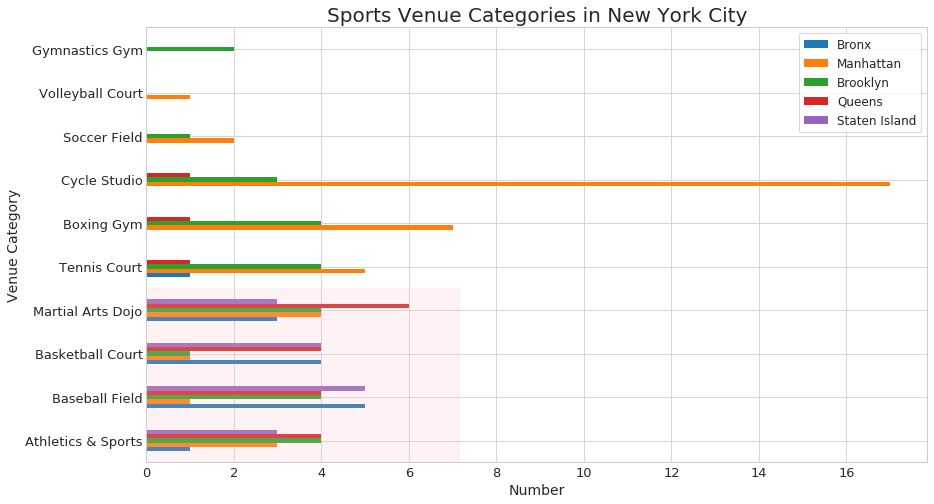

In [70]:
import matplotlib.patches as patches

venue_category_merged_outer[['Bronx','Manhattan','Brooklyn','Queens','Staten Island']].plot(kind = 'barh', figsize=(14,8))
plt.legend(fontsize = 12, loc = 'best', frameon = True)
plt.xlabel('Number', fontsize = 14)
plt.ylabel('Venue Category', fontsize = 14)
plt.title('Sports Venue Categories in New York City', fontsize = 20)
plt.xticks(fontsize = 13)
plt.yticks(fontsize = 13)

# Create a Rectangle patch
plt.axhspan(ymin = -1, ymax=3.5, xmin=0, xmax=0.4, alpha = 0.2, color ='pink')

(array([0, 1, 2, 3]), <a list of 4 Text yticklabel objects>)

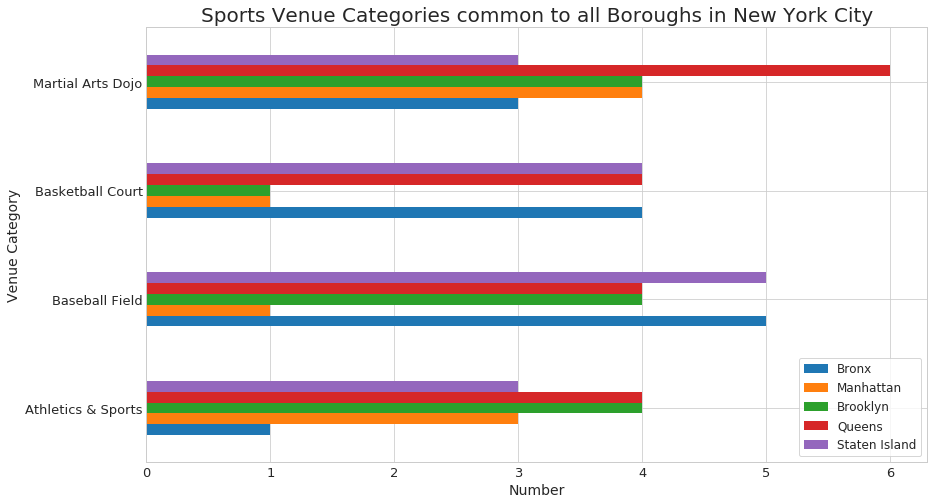

In [71]:
venue_category_merged_inner.plot(kind = 'barh', figsize=(14,8))
plt.legend(fontsize = 12, loc = 'best', frameon = True)
plt.xlabel('Number', fontsize = 14)
plt.ylabel('Venue Category', fontsize = 14)
plt.title('Sports Venue Categories common to all Boroughs in New York City', fontsize = 20)
plt.xticks(fontsize = 13)
plt.yticks(fontsize = 13)

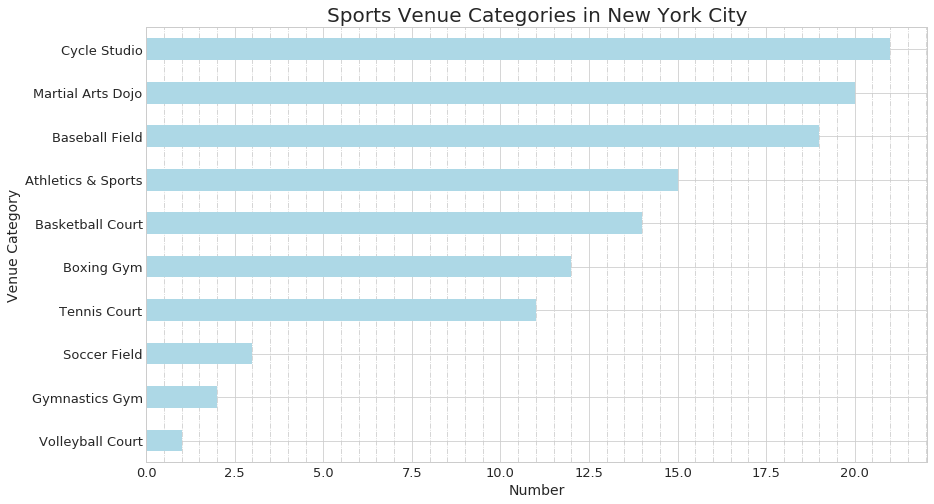

In [72]:
fig, ax = plt.subplots()
Total_df.sort_values(['Total'], ascending=True).plot(kind = 'barh', figsize=(14,8), legend = None, color='lightblue', ax=ax)
plt.title('Sports Venue Categories in New York City', fontsize = 20)
plt.xlabel('Number', fontsize = 14)
plt.ylabel('Venue Category', fontsize = 14)
plt.xticks(fontsize = 13)
plt.yticks(fontsize = 13)
# Turn on the minor TICKS, which are required for the minor GRID
ax.minorticks_on()
# Customize the minor grid
ax.grid(axis = 'x', which='minor', linestyle= '-.')
plt.show()

#### Let's find out how many unique categories can be curated from all the returned venues

In [73]:
print('In The Bronx there are {} unique categories.'.format(len(bronx_sports_df['Venue Category'].unique())))
print('In Manhattan there are {} unique categories.'.format(len(manhattan_sports_df['Venue Category'].unique())))
print('In Brooklyn there are {} unique categories.'.format(len(brooklyn_sports_df['Venue Category'].unique())))
print('In Queens there are {} unique categories.'.format(len(queens_sports_df['Venue Category'].unique())))
print('In Staten Island there are {} unique categories.'.format(len(statenisland_sports_df['Venue Category'].unique())))
print('In New York City there are {} unique categories.'.format(len(NYC_sports_df['Venue Category'].unique())))

In The Bronx there are 5 unique categories.
In Manhattan there are 9 unique categories.
In Brooklyn there are 9 unique categories.
In Queens there are 7 unique categories.
In Staten Island there are 4 unique categories.
In New York City there are 10 unique categories.


## 3. Analyze the New York City data

In [74]:
# New York City
# one hot encoding
NYC_sports_onehot = pd.get_dummies(NYC_sports_df[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
NYC_sports_onehot['Neighborhood'] = NYC_sports_df['Neighborhood'] 

# move neighborhood column to the first column
first_col = NYC_sports_onehot.pop('Neighborhood')
NYC_sports_onehot.insert(0, 'Neighborhood', first_col)

print('New York City')
NYC_sports_onehot.head()

##############################################

New York City


,Neighborhood,Athletics & Sports,Baseball Field,Basketball Court,Boxing Gym,Cycle Studio,Gymnastics Gym,Martial Arts Dojo,Soccer Field,Tennis Court,Volleyball Court
0,Co-op City,0,1,0,0,0,0,0,0,0,0
1,Co-op City,0,0,1,0,0,0,0,0,0,0
2,City Island,0,1,0,0,0,0,0,0,0,0
3,West Farms,0,0,1,0,0,0,0,0,0,0
4,Melrose,0,0,0,0,0,0,1,0,0,0


And let's examine the new dataframe size.

#### Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [75]:
NYC_sports_grouped = NYC_sports_onehot.groupby('Neighborhood').mean().reset_index()
NYC_sports_grouped.head()

,Neighborhood,Athletics & Sports,Baseball Field,Basketball Court,Boxing Gym,Cycle Studio,Gymnastics Gym,Martial Arts Dojo,Soccer Field,Tennis Court,Volleyball Court
0,Allerton,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,Arrochar,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Astoria,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,Auburndale,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Battery Park City,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Let's confirm the new size

In [76]:
# Function definition is here
def shapefunction( str, data ):
    print(str,': ', data.shape)
    return

shapefunction('New York City grouped shape', NYC_sports_grouped)

New York City grouped shape :  (85, 11)


#### Let's print each neighborhood along with the top 5 most common venues

#### Let's put that into a *pandas* dataframe

First, let's write a function to sort the venues in descending order.

In [77]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 5 venues for each neighborhood.

In [78]:
indicators = ['st', 'nd', 'rd']

#---------------------------------------------------------------------------------------------------------
def neighborhoods_venues_sorted(str, num_top_venues, sports_grouped):
# create columns according to number of top venues
    columns = ['Neighborhood']
    for ind in np.arange(num_top_venues):
        try:
            columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
        except:
            columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
    neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
    neighborhoods_venues_sorted['Neighborhood'] = sports_grouped['Neighborhood']

    for ind in np.arange(sports_grouped.shape[0]):
     neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(sports_grouped.iloc[ind, :], num_top_venues)
 
    print('Top', num_top_venues, 'venues per neighboorhood in', str)
    return neighborhoods_venues_sorted

In [79]:
NYC_neighborhoods_venues_sorted = neighborhoods_venues_sorted('NYC', 5, NYC_sports_grouped)
NYC_neighborhoods_venues_sorted.head()

Top 5 venues per neighboorhood in NYC


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Allerton,Martial Arts Dojo,Volleyball Court,Tennis Court,Soccer Field,Gymnastics Gym
1,Arrochar,Athletics & Sports,Volleyball Court,Tennis Court,Soccer Field,Martial Arts Dojo
2,Astoria,Martial Arts Dojo,Volleyball Court,Tennis Court,Soccer Field,Gymnastics Gym
3,Auburndale,Athletics & Sports,Volleyball Court,Tennis Court,Soccer Field,Martial Arts Dojo
4,Battery Park City,Athletics & Sports,Volleyball Court,Tennis Court,Soccer Field,Martial Arts Dojo


## 4. Cluster Neighborhoods

Run *k*-means to cluster the neighborhood into 5 clusters.

In [88]:
# Drop Neighborhood column first
NYC_sports_grouped_clustering = NYC_sports_grouped.drop('Neighborhood', 1)

In [89]:
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    NYC_kmeans = KMeans(n_clusters=k, random_state=0).fit(NYC_sports_grouped_clustering)
    Sum_of_squared_distances.append(NYC_kmeans.inertia_)

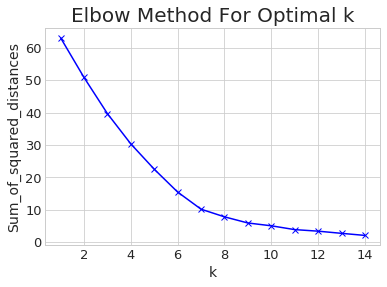

In [90]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k', fontsize = 14)
plt.ylabel('Sum_of_squared_distances', fontsize = 14)
plt.title('Elbow Method For Optimal k', fontsize = 20)
plt.xticks(fontsize = 13)
plt.yticks(fontsize = 13)
plt.show()

In [91]:
# set optimal number of clusters
kclusters = 7

# run k-means clustering
def clusters(sports_grouped_clustering):
    kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(sports_grouped_clustering)
    return kmeans

NYC_kmeans = clusters(NYC_sports_grouped_clustering)

# check cluster labels generated for each row in the dataframe
print(NYC_kmeans.labels_[0:10])
NYC_kmeans.labels_.size

[4 5 4 5 5 4 5 5 5 3]


85

In [92]:
# Function to create the merged clusters per borough
def cluster_merge(neighborhoods_venues_sorted, labels, boroughdata):
    # add clustering labels
     neighborhoods_venues_sorted.insert(0, 'Cluster Labels', labels)
     merged = boroughdata
     merged.sort_values('Neighborhood').head()
     merged = pd.merge(merged, neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')
     return merged

In [93]:
NYC_merged = cluster_merge(NYC_neighborhoods_venues_sorted, NYC_kmeans.labels_, neighborhoods)
NYC_merged.head()

ValueError: cannot insert Cluster Labels, already exists

Finally, let's visualize the resulting clusters

#### Clusters for New York City

In [133]:
# create map
map_clusters = folium.Map(location=[nylatitude, nylongitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
#rainbow = [colors.rgb2hex(i) for i in colors_array]

rainbow =['red', 'green', 'blue', 'yellow', 'orange', 'purple', 'grey']

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(NYC_merged['Latitude'], NYC_merged['Longitude'], NYC_merged['Neighborhood'], NYC_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster+1), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.5).add_to(map_clusters)

#-----------------------------------------------------
# Add a legend for the clusters by Colin Talbert @ http://nbviewer.jupyter.org/gist/talbertc-usgs/18f8901fc98f109f2b71156cf3ac81cd
from branca.element import Template, MacroElement

template = """
{% macro html(this, kwargs) %}

<!doctype html>
<html lang="en">
<head>
  <meta charset="utf-8">
  <meta name="viewport" content="width=device-width, initial-scale=1">
  <title>jQuery UI Draggable - Default functionality</title>
  <link rel="stylesheet" href="//code.jquery.com/ui/1.12.1/themes/base/jquery-ui.css">

  <script src="https://code.jquery.com/jquery-1.12.4.js"></script>
  <script src="https://code.jquery.com/ui/1.12.1/jquery-ui.js"></script>
  
  <script>
  $( function() {
    $( "#maplegend" ).draggable({
                    start: function (event, ui) {
                        $(this).css({
                            right: "auto",
                            top: "auto",
                            bottom: "auto"
                        });
                    }
                });
});

  </script>
</head>
<body>

<div id='maplegend' class='maplegend' 
    style='position: absolute; z-index:9999; border:2px solid grey; background-color:rgba(255, 255, 255, 0.8);
     border-radius:6px; padding: 10px; font-size:14px; right: 20px; bottom: 20px;'>
     
<div class='legend-title'>Clusters Legend</div>
<div class='legend-scale'>
  <ul class='legend-labels'>
    <li><span style='background:red;opacity:0.7;'></span>Cluster 1</li>
    <li><span style='background:green;opacity:0.7;'></span>Cluster 2</li>
    <li><span style='background:blue;opacity:0.7;'></span>Cluster 3</li>
    <li><span style='background:yellow;opacity:0.7;'></span>Cluster 4</li>
    <li><span style='background:orange;opacity:0.7;'></span>Cluster 5</li>
    <li><span style='background:purple;opacity:0.7;'></span>Cluster 6</li>
    <li><span style='background:grey;opacity:0.7;'></span>Cluster 7</li>
  </ul>
</div>
</div>
 
</body>
</html>

<style type='text/css'>
  .maplegend .legend-title {
    text-align: left;
    margin-bottom: 5px;
    font-weight: bold;
    font-size: 90%;
    }
  .maplegend .legend-scale ul {
    margin: 0;
    margin-bottom: 5px;
    padding: 0;
    float: left;
    list-style: none;
    }
  .maplegend .legend-scale ul li {
    font-size: 80%;
    list-style: none;
    margin-left: 0;
    line-height: 18px;
    margin-bottom: 2px;
    }
  .maplegend ul.legend-labels li span {
    display: block;
    float: left;
    height: 16px;
    width: 30px;
    margin-right: 5px;
    margin-left: 0;
    border: 1px solid #999;
    }
  .maplegend .legend-source {
    font-size: 80%;
    color: #777;
    clear: both;
    }
  .maplegend a {
    color: #777;
    }
</style>
{% endmacro %}"""

macro = MacroElement()
macro._template = Template(template)

map_clusters.get_root().add_child(macro)
#-----------------------------------------------------

map_clusters.save('NYC_Clusters_Map.html')    

map_clusters

## 5. Examine Clusters

Now, you can examine each cluster and determine the discriminating venue categories that distinguish each cluster. Based on the defining categories, you can then assign a name to each cluster. I will leave this exercise to you.

### New York City Clusters

In [80]:
NYC_merged.sort_values('Cluster Labels')

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
27,Brooklyn,North Side,40.714823,-73.958809,0,Cycle Studio,Boxing Gym,Volleyball Court,Tennis Court,Soccer Field
49,Queens,Forest Hills,40.725264,-73.844475,0,Martial Arts Dojo,Boxing Gym,Volleyball Court,Tennis Court,Soccer Field
15,Brooklyn,Greenpoint,40.730201,-73.954241,0,Gymnastics Gym,Volleyball Court,Tennis Court,Soccer Field,Martial Arts Dojo
37,Manhattan,Murray Hill,40.748303,-73.978332,0,Boxing Gym,Volleyball Court,Tennis Court,Soccer Field,Martial Arts Dojo
26,Brooklyn,East Williamsburg,40.708492,-73.938858,0,Gymnastics Gym,Volleyball Court,Tennis Court,Soccer Field,Martial Arts Dojo
36,Manhattan,Midtown,40.754691,-73.981669,0,Cycle Studio,Martial Arts Dojo,Boxing Gym,Volleyball Court,Tennis Court
21,Brooklyn,Marine Park,40.609748,-73.931344,0,Soccer Field,Basketball Court,Baseball Field,Athletics & Sports,Volleyball Court
22,Brooklyn,Clinton Hill,40.693229,-73.967843,0,Boxing Gym,Volleyball Court,Tennis Court,Soccer Field,Martial Arts Dojo
42,Manhattan,Tribeca,40.721522,-74.010683,0,Volleyball Court,Cycle Studio,Basketball Court,Tennis Court,Soccer Field
73,Manhattan,Noho,40.723259,-73.988434,0,Boxing Gym,Volleyball Court,Tennis Court,Soccer Field,Martial Arts Dojo


In [81]:
headers = ['Borough', 'Neighborhood','1st Most Common Venue', '2nd Most Common Venue', '3rd Most Common Venue', '4th Most Common Venue', '5th Most Common Venue']

#### New York City Cluster 1

In [82]:
Cluster1 = NYC_merged[NYC_merged['Cluster Labels'] == 0]
Cluster1[headers].head()

,Borough,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
15,Brooklyn,Greenpoint,Gymnastics Gym,Volleyball Court,Tennis Court,Soccer Field,Martial Arts Dojo
21,Brooklyn,Marine Park,Soccer Field,Basketball Court,Baseball Field,Athletics & Sports,Volleyball Court
22,Brooklyn,Clinton Hill,Boxing Gym,Volleyball Court,Tennis Court,Soccer Field,Martial Arts Dojo
24,Brooklyn,Boerum Hill,Tennis Court,Martial Arts Dojo,Athletics & Sports,Volleyball Court,Soccer Field
26,Brooklyn,East Williamsburg,Gymnastics Gym,Volleyball Court,Tennis Court,Soccer Field,Martial Arts Dojo


#### New York City Cluster 2

In [83]:
Cluster2 = NYC_merged[NYC_merged['Cluster Labels'] == 1]
Cluster2[headers].head()

,Borough,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Bronx,Co-op City,Baseball Field,Volleyball Court,Tennis Court,Soccer Field,Martial Arts Dojo
3,Bronx,City Island,Baseball Field,Volleyball Court,Tennis Court,Soccer Field,Martial Arts Dojo
4,Bronx,Bedford Park,Baseball Field,Volleyball Court,Tennis Court,Soccer Field,Martial Arts Dojo
7,Bronx,Mott Haven,Baseball Field,Volleyball Court,Tennis Court,Soccer Field,Martial Arts Dojo
8,Bronx,Port Morris,Baseball Field,Volleyball Court,Tennis Court,Soccer Field,Martial Arts Dojo


#### New York City Cluster 3

In [84]:
Cluster3 = NYC_merged[NYC_merged['Cluster Labels'] == 2]
Cluster3[headers].head()

,Borough,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
2,Bronx,Norwood,Athletics & Sports,Volleyball Court,Tennis Court,Soccer Field,Martial Arts Dojo
10,Bronx,Country Club,Athletics & Sports,Volleyball Court,Tennis Court,Soccer Field,Martial Arts Dojo
17,Brooklyn,Brooklyn Heights,Cycle Studio,Athletics & Sports,Volleyball Court,Tennis Court,Soccer Field
32,Manhattan,Yorkville,Soccer Field,Athletics & Sports,Volleyball Court,Tennis Court,Martial Arts Dojo
45,Manhattan,Battery Park City,Athletics & Sports,Volleyball Court,Tennis Court,Soccer Field,Martial Arts Dojo


#### New York City Cluster 4

In [85]:
Cluster4 = NYC_merged[NYC_merged['Cluster Labels'] == 3]
Cluster4[headers].head()

,Borough,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
30,Manhattan,Central Harlem,Cycle Studio,Volleyball Court,Tennis Court,Soccer Field,Martial Arts Dojo
31,Manhattan,Upper East Side,Cycle Studio,Volleyball Court,Tennis Court,Soccer Field,Martial Arts Dojo
33,Manhattan,Lenox Hill,Cycle Studio,Volleyball Court,Tennis Court,Soccer Field,Martial Arts Dojo
35,Manhattan,Lincoln Square,Cycle Studio,Volleyball Court,Tennis Court,Soccer Field,Martial Arts Dojo
39,Manhattan,Chelsea,Cycle Studio,Volleyball Court,Tennis Court,Soccer Field,Martial Arts Dojo


#### New York City Cluster 5

In [86]:
Cluster5 = NYC_merged[NYC_merged['Cluster Labels'] == 4]
Cluster5[headers].head()

,Borough,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
5,Bronx,West Farms,Basketball Court,Volleyball Court,Tennis Court,Soccer Field,Martial Arts Dojo
14,Bronx,Olinville,Basketball Court,Volleyball Court,Tennis Court,Soccer Field,Martial Arts Dojo
48,Queens,Corona,Basketball Court,Volleyball Court,Tennis Court,Soccer Field,Martial Arts Dojo
57,Queens,Floral Park,Basketball Court,Volleyball Court,Tennis Court,Soccer Field,Martial Arts Dojo
60,Staten Island,Port Richmond,Basketball Court,Volleyball Court,Tennis Court,Soccer Field,Martial Arts Dojo


#### New York City Cluster 6

In [87]:
Cluster6 = NYC_merged[NYC_merged['Cluster Labels'] == 5]
Cluster6[headers].head()

,Borough,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
1,Bronx,Kingsbridge,Martial Arts Dojo,Volleyball Court,Tennis Court,Soccer Field,Gymnastics Gym
6,Bronx,Melrose,Martial Arts Dojo,Volleyball Court,Tennis Court,Soccer Field,Gymnastics Gym
12,Bronx,Belmont,Martial Arts Dojo,Volleyball Court,Tennis Court,Soccer Field,Gymnastics Gym
18,Brooklyn,Gowanus,Martial Arts Dojo,Volleyball Court,Tennis Court,Soccer Field,Gymnastics Gym
23,Brooklyn,Downtown,Martial Arts Dojo,Volleyball Court,Tennis Court,Soccer Field,Gymnastics Gym


#### New York City Cluster 7

In [88]:
Cluster7 = NYC_merged[NYC_merged['Cluster Labels'] == 6]
Cluster7[headers].head()

,Borough,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
13,Bronx,Spuyten Duyvil,Tennis Court,Volleyball Court,Soccer Field,Martial Arts Dojo,Gymnastics Gym
19,Brooklyn,Fort Greene,Tennis Court,Volleyball Court,Soccer Field,Martial Arts Dojo,Gymnastics Gym
29,Brooklyn,Fort Hamilton,Tennis Court,Volleyball Court,Soccer Field,Martial Arts Dojo,Gymnastics Gym
41,Manhattan,Lower East Side,Tennis Court,Volleyball Court,Soccer Field,Martial Arts Dojo,Gymnastics Gym
44,Manhattan,Morningside Heights,Tennis Court,Volleyball Court,Soccer Field,Martial Arts Dojo,Gymnastics Gym
